In [334]:
%matplotlib inline
import numpy as np
import pandas as pd
from qutip import *
import plotly.express as px
import matplotlib.pyplot as plt

In [335]:
E = 1.0                # two level energy difference
N = 3                 # number of phonon quanta needed to exite the atom
E_phonon = E / N       # phonon energy
M = 8             # maximum number of phonons to simulate
ng = 50            # number of different coupling strengths to try out (need 100 to reproduce SJByrnes Moiré pattern)
max_coupling = 0.7*E   # maximum atom phonon coupling 

In [336]:
d = {"coupling":np.linspace(0,max_coupling,ng)}
for i in range(2*M):
    d[f"energy_{i}"] = np.zeros(ng)
    
df = pd.DataFrame(data=d)
#df

In [337]:
couplings=np.linspace(0,max_coupling,ng)


In [338]:
a  = tensor(destroy(M), qeye(2)) # phonon destruction operator
sm = tensor(qeye(M), sigmam())   # sigma_minus operator which is often called a lowering operator
sz = tensor(qeye(M),sigmaz())    # z component of the "spin" of the two level system

In [339]:
for index, row in df.iterrows():
    # c.f. https://coldfusionblog.net/2017/07/09/numerical-spin-boson-model-part-1/
    H = E*sz/2 + E_phonon*(a.dag()*a+0.5) + row.coupling*(a.dag() + a) * (sm + sm.dag())
    evals, ekets = H.eigenstates()
    df.iloc[index,1:] = evals/E_phonon
    
#print("\nSample row from the dataframe\n")



In [340]:
melt = df.melt(id_vars=["coupling"],var_name="level",value_name="energy")


In [341]:
fig = px.line(melt,x="coupling",y="energy",color="level",width=900,height=600)
fig.layout.showlegend = False 
fig.show()  # Don't use plot when you have M ~ 1000 it will likely grind to a hault
# fig.write_image("levels.png")


In [342]:
couplings=np.linspace(0,max_coupling,ng)
evals=[]  #different evals per different couplings
ekets=[]



In [343]:
#Want to store all Eigenvectors in a Matlab-like fashon
for ii in range(len(couplings)):
    # c.f. https://coldfusionblog.net/2017/07/09/numerical-spin-boson-model-part-1/
    H = E*sz/2 + E_phonon*(a.dag()*a+0.5) + couplings[ii]*(a.dag() + a) * (sm + sm.dag())
    evals_t, ekets_t = H.eigenstates()
    evals.append(evals_t)
    ekets.append(ekets_t)
    #df.iloc[index,1:] = evals/E_phonon

    
evals_m = np.matrix(evals)  #not dividing per E_phonon
ekets_m = np.matrix(ekets)
## evals[ N_coupling , 2*M = 2* max numebr of phonons  ]
## evals[ moving rightwards , moving upwards  ] in the above plot
## ekets[]  same thing for the ekets aka Eigenvstates  

#ekets_m[1,0] #Eigenstate of the first coupling non 0 and the ground state 0 

Let's try to plot the coupling dependency one single eigenvalue

In [344]:
N_comp=20 #number of vectors into which to decompose the which_state
which_state=6   # 1 means ground state,  which state 

if N_comp > 2*M:
    N_comp=2*M
    
if which_state > 2*M:
    which_state=2*M

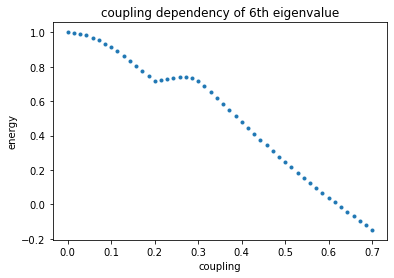

In [345]:

plt.plot(couplings,evals_m[:,which_state-1],'.')
plt.xlabel('coupling')
plt.ylabel('energy')
plt.title(f'coupling dependency of {which_state}th eigenvalue')
plt.show()


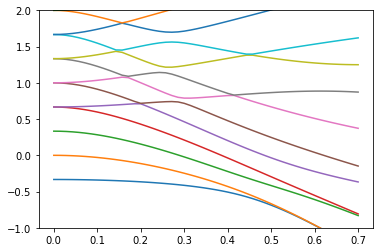

In [346]:
rows , columns =evals_m.shape
#plot with no correction of the E_phonon
for ii in range(columns):
    plt.plot(couplings,evals_m[:,ii])
    


axes = plt.gca()
axes.set_ylim([-1,2])

plt.show()

The discontinuity shows that if you follow the i-th eigenvalue, you are making a jump in the state.

Let's try to plot the components of the eigenstates as we go towards higher couplings 

Already from the 5th state (with current parapeters; first state that

In [347]:

c2=np.zeros((N_comp,len(couplings)))  
#c squared aka probabability for the eigenstates to be found in the first 
#N_comp basis componets (of the 0 interaction hamiltoniam) )

for ii in range(N_comp):
    for jj in range(len(couplings)):
        c0_dag_c = ( ekets_m[0,ii].dag() * ekets_m[jj, which_state-1 ]).full()  
        # ^ full() makes a Qobj into a array
        c2[ii,jj] = ( abs(c0_dag_c[0,0])**2 )
        
#if you want to see the components
Visual_c2=Qobj(c2)   #just to see 
## c2[ i-th eigenstate of 0 coupling , couplings  ]

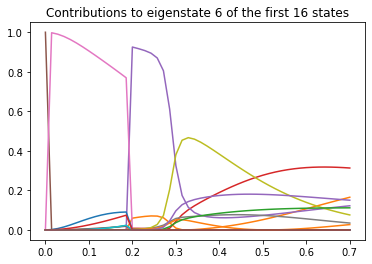

In [348]:
plt.figure()
for ii in range(N_comp):
    plt.plot(couplings,c2[ii,:], label=ii+1)
    
plt.title(f'Contributions to eigenstate {which_state} of the first {N_comp} states')    
#plt.legend()
plt.show()

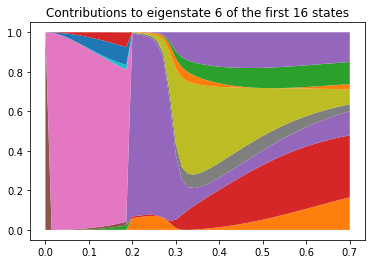

In [349]:
plt.fill_between(couplings, 0*c2[0,:], c2[0,:], label=0)

for ii in range(N_comp-1):
    plt.fill_between(couplings, np.sum(c2[0:ii+1,:], axis=0), np.sum(c2[0:ii+2,:], axis=0), label=ii+1)
#plt.legend()
plt.title(f'Contributions to eigenstate {which_state} of the first {N_comp} states') 
plt.show()

We try now to follow the eigenstate of the "same" eigenvalue (follow the smooth curve), and see if its components are "continous"

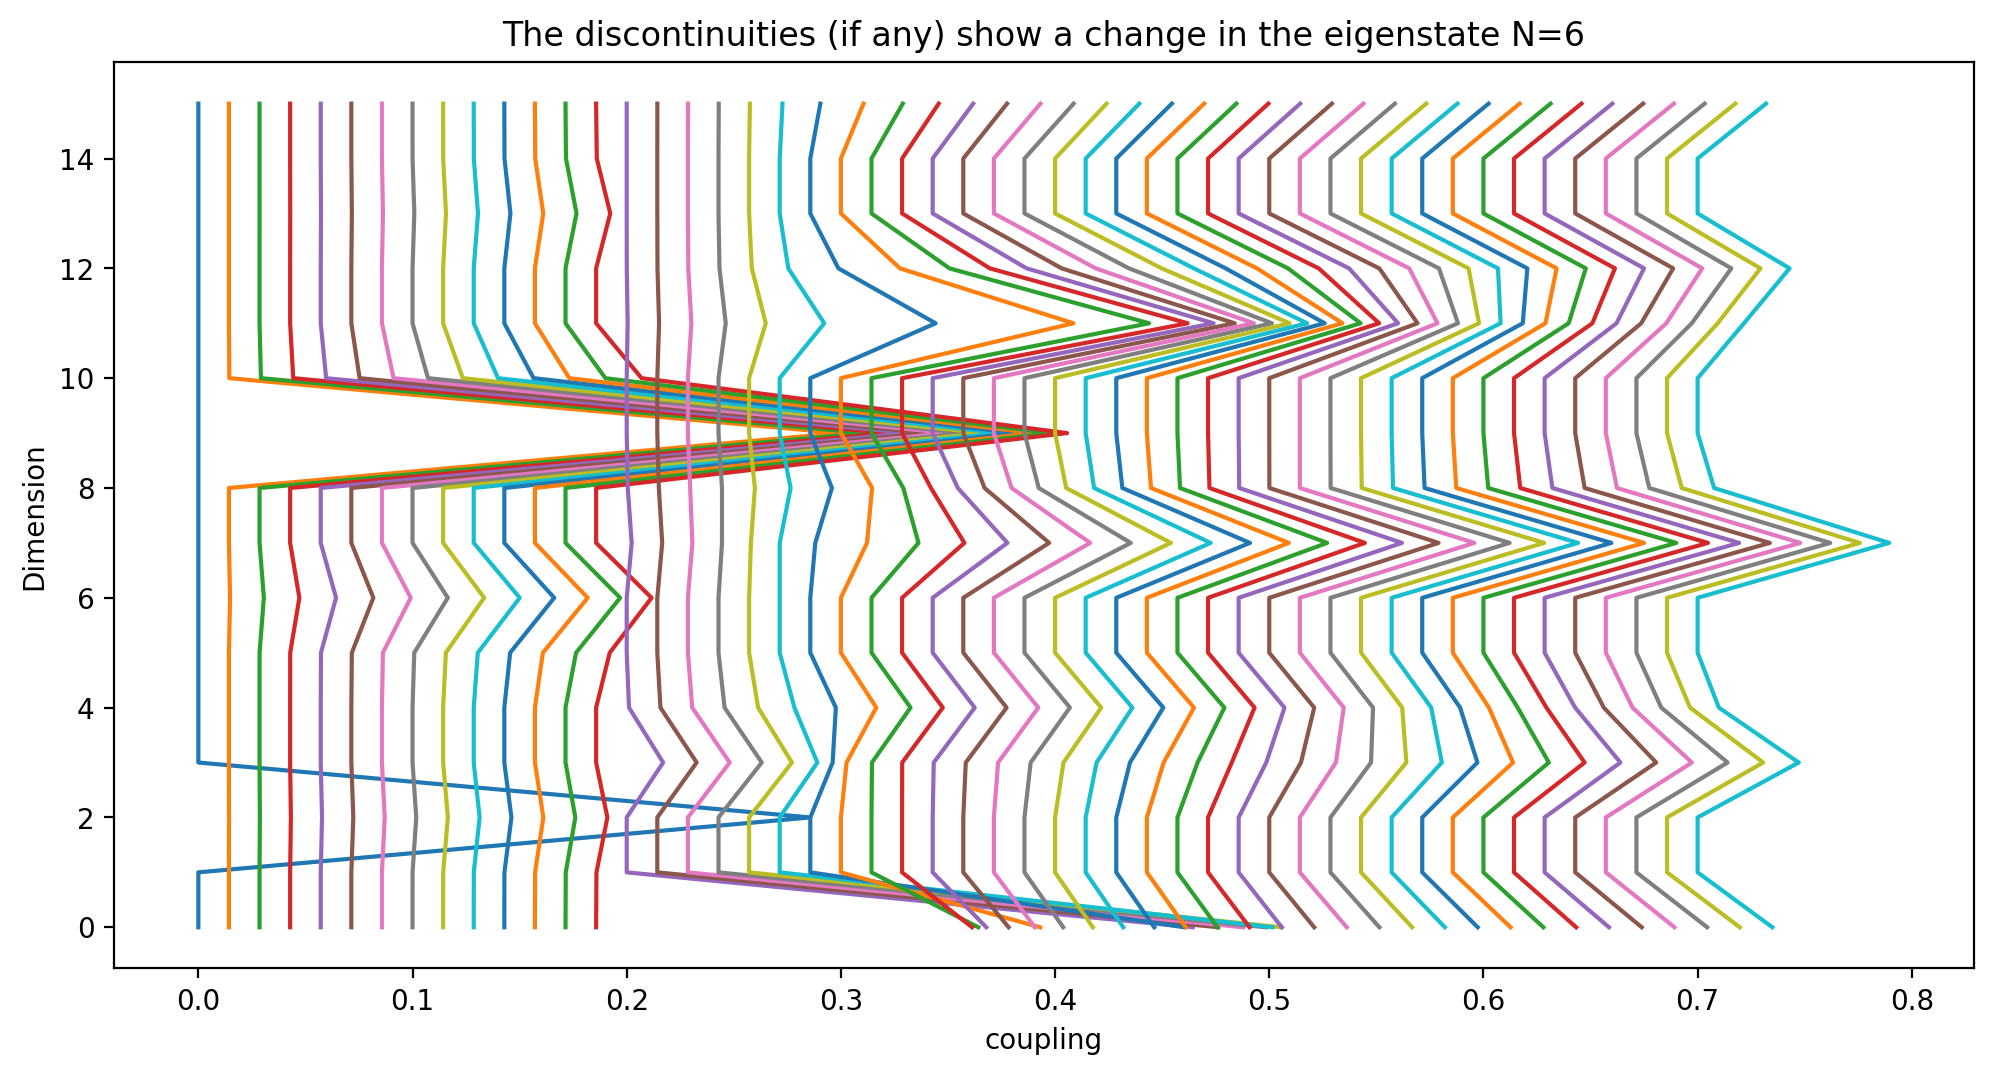

In [350]:
state=which_state  #ground state ==1
plt.figure(num=None, figsize=(12, 6), dpi=200, facecolor='w', edgecolor='k')

for ii in range(len(couplings)):
    eket_profile= abs( ekets_m[ii,state-1].full()  ) **2
    plt.plot(eket_profile*20*couplings[1]+couplings[ii], range(len(eket_profile)))

plt.title(f'The discontinuities (if any) show a change in the eigenstate N={state}')
plt.xlabel('coupling')
plt.ylabel('Dimension')
plt.show()


# We should find the continous states by finding the closest eigenstates at each coupling, iterating from the minimal  coupling to the highest, step by step

In [351]:
e_ord=np.zeros(ekets_m.shape) #preparing the real ordering of the eigenvalues/eigenstates
e_ord[0,:]=range(len(e_ord[0,:]))  #assigning values at 0 coupling

rows , columns =evals_m.shape #just to remeber the number of couplings and the number of eigenvalues

for ii in range(1,len(couplings)):
    
    for kk in range(columns):  #iteration for the comparison of the previous eigenstate
        distances=np.zeros(columns)
        
        for jj in range(columns):  #iteration for the comparison of the later eigenstate
            distances[jj] = np.linalg.norm(abs(ekets_m[ii-1,kk].full())**2-abs(ekets_m[ii,jj].full())**2)
            
        idx_min=np.argmin(distances)
        
        e_ord[ii, idx_min  ]=e_ord[ii-1,kk]


e_ord=e_ord.astype(int)
#e_ord  #matrix containing the right ordering for smooth transitions among couplings


In [352]:
#ordered containers of eigenstates and eigencvalues

ekets_mo = ekets_m*0  
evals_mo = evals_m*0


for ii in range(len(couplings)):
    for kk in range(columns):
        ekets_mo[ ii, e_ord[ii,kk] ]= ekets_m[ii, kk]
        evals_mo[ ii, e_ord[ii,kk] ]= evals_m[ii, kk]
        

Still it is not correct, we solved some intersections, but some show discontinuites in the eigenvalue range

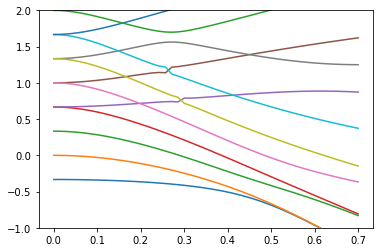

In [353]:

#plot with no correction of the E_phonon


for ii in range(columns):
    plt.plot(couplings,evals_mo[:,ii])
    


axes = plt.gca()
axes.set_ylim([-1,2])

plt.show()

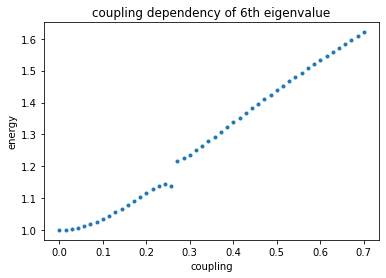

In [354]:

plt.plot(couplings,evals_mo[:,which_state-1],'.')
plt.xlabel('coupling')
plt.ylabel('energy')
plt.title(f'coupling dependency of {which_state}th eigenvalue')
plt.show()

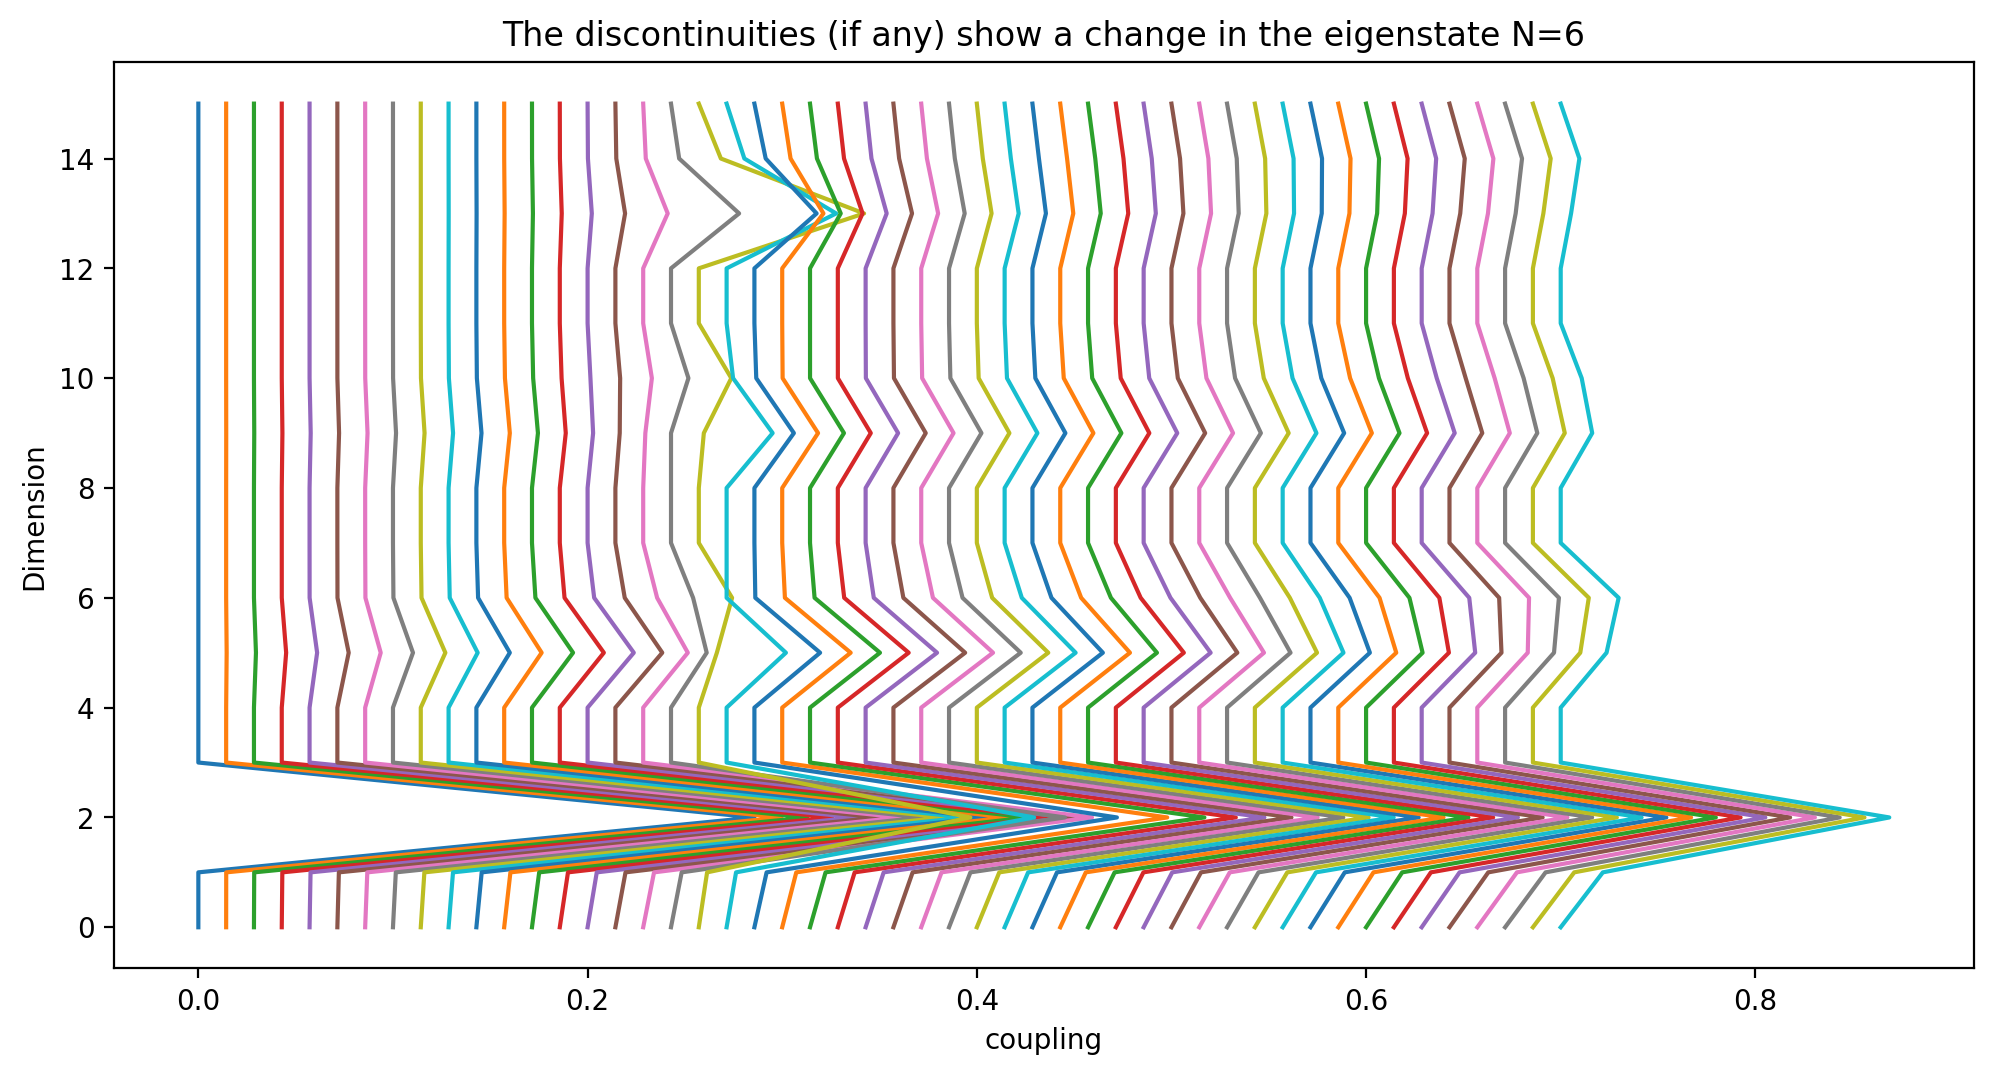

In [355]:
state=which_state  #ground state ==1
plt.figure(num=None, figsize=(12, 6), dpi=200, facecolor='w', edgecolor='k')

for ii in range(len(couplings)):
    eket_profile= abs( ekets_mo[ii,state-1].full()  ) **2
    plt.plot(eket_profile*20*couplings[1]+couplings[ii], range(len(eket_profile)))

plt.title(f'The discontinuities (if any) show a change in the eigenstate N={state}')
plt.xlabel('coupling')
plt.ylabel('Dimension')
plt.show()


In [356]:

c2o=np.zeros((N_comp,len(couplings)))  
#c squared aka probabability for the eigenstates to be found in the first 
#N_comp basis componets (of the 0 interaction hamiltoniam) )

for ii in range(N_comp):
    for jj in range(len(couplings)):
        c0_dag_c = ( ekets_mo[0,ii].dag() * ekets_mo[jj, which_state-1 ]).full()  
        # ^ full() makes a Qobj into a array
        c2o[ii,jj] = ( abs(c0_dag_c[0,0])**2 )
        
#if you want to see the components
 
## c2[ i-th eigenstate of 0 coupling , couplings  ]

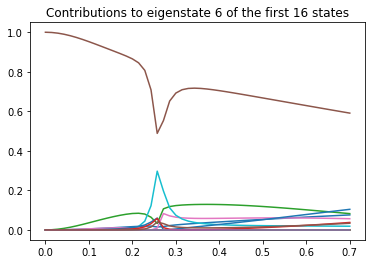

In [357]:
plt.figure()
for ii in range(N_comp):
    plt.plot(couplings,c2o[ii,:], label=ii+1)
    
plt.title(f'Contributions to eigenstate {which_state} of the first {N_comp} states')    
#plt.legend()
plt.show()

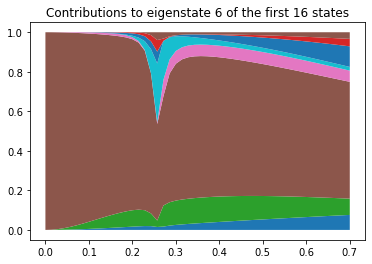

In [358]:
plt.fill_between(couplings, 0*c2o[0,:], c2o[0,:], label=0)

for ii in range(N_comp-1):
    plt.fill_between(couplings, np.sum(c2o[0:ii+1,:], axis=0), np.sum(c2o[0:ii+2,:], axis=0), label=ii+1)
#plt.legend()
plt.title(f'Contributions to eigenstate {which_state} of the first {N_comp} states') 
plt.show()